# ARMA Primer

## Definitions

Recall that a **Moving Average** (MA) process is y(t) such that:

$y(t) = 
\mu + 
\epsilon_t - 
\theta_1  \epsilon_{t-1} -
\theta_2  \epsilon_{t-2} -
...
\theta_q  \epsilon_{t-q}
$

with 
$\epsilon_t ~ WN(0,\sigma^2)$

And an **Auto Regressive** (AR) process is y(t) such that:

$y(t) = 
\mu + 
\phi_1  y_{t-1} +
\phi_2  y_{t-2} +
...
\phi_q  y_{t-2} +
\epsilon_t
$

again with 
$\epsilon_t ~ WN(0,\sigma^2)$



And an **ARMA** process is y(t) such that:

$y(t) = 
\mu + 
\phi_1  y_{t-1} +
\phi_2  y_{t-2} +
... +
\phi_q  y_{t-2} +
\epsilon_t -
\theta_1  \epsilon_{t-1} -
\theta_2  \epsilon_{t-2} -
... -
\theta_q  \epsilon_{t-q}
$



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import scipy.signal as ssig

from statsmodels.tsa.arima.model import ARIMA

#from .helpers import compare_real_and_imaginary
from aurora.sandbox.plot_helpers import compare_real_and_imaginary

In [2]:
# Uncomment the following line to make plots interactive.
%matplotlib widget

In [3]:
seed = 1
np.random.seed(seed)

## A simple MA example with shaped noise

Make a noise time series.  Then shape it by applying a known ARMA filter.  Then, cheat a bit by fitting an ARMA model of the same order as the shaping filter.

Use this toy example to get a feel for the ARMA coefficents and how they prewhiten

In [4]:
N = 1024 # 128#0000
noise = np.random.random(N)
noise -= np.mean(noise)
MA = [0.25, 0.5, 0.25]
AR = [1, 0.9]
ar_order = len(AR) - 1
ma_order = len(MA)
# MA = np.array([1/4, 1/4,1/4,1/4])
# AR = [1, -0.1, -.3]

offset = int(len(MA)/2)
# Offset will in generl depend on the difference in the MA, AR orders (I think)
#shaped_noise = np.convolve(noise, MA, "same")
shaped_noise = ssig.lfilter(MA,AR, noise)
shaped_noise -= np.mean(shaped_noise)
#shaped_noise = ssig.lfilter(MA,[1], noise)
noise_spec = np.fft.fft(noise)
shaped_noise_spec = np.fft.fft(shaped_noise)

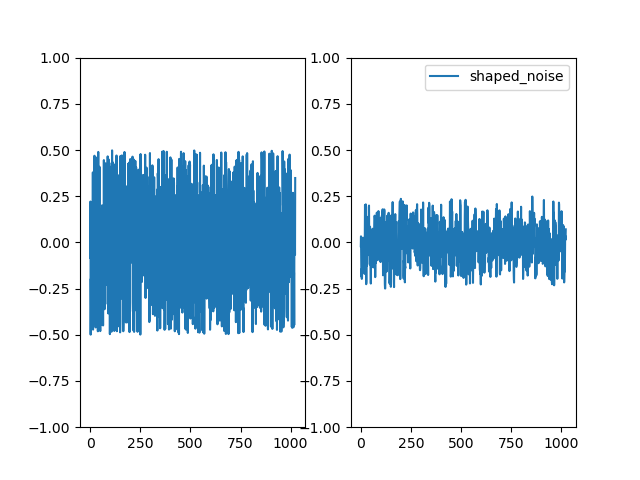

In [5]:
fig, axs = plt.subplots(ncols=2)
ylims = [-1, 1]
axs[0].plot(noise, label="noise")
axs[0].set_ylim(ylims)
axs[1].plot(shaped_noise, label="shaped_noise")
axs[1].set_ylim(ylims)
plt.legend()

Figure  **Noise and Shaped**: The original noise time series, and the MA filtered version

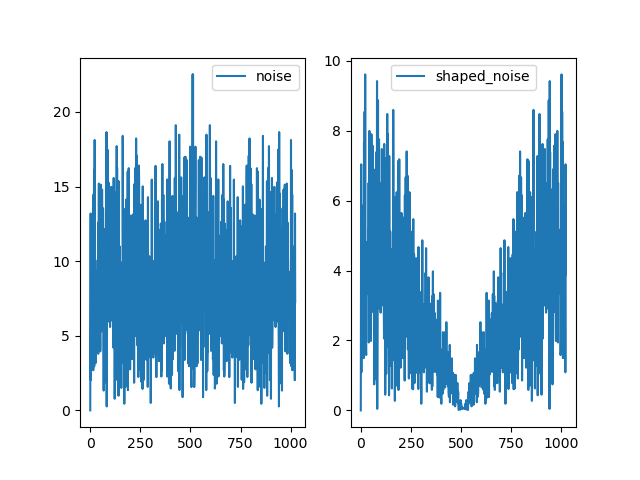

In [6]:
fig, axs = plt.subplots(ncols=2)
#ylims = [-1, 1]
axs[0].plot(np.abs(noise_spec), label="noise")
#axs[0].set_ylim(ylims)
axs[1].plot(np.abs(shaped_noise_spec), label="shaped_noise")
#axs[1].set_ylim(ylims)
axs[0].legend()
axs[1].legend()


Figure  **Noise and Shaped Spectra**: The original noise time series, and the filtered version

In [7]:
arma_mod = ARIMA(shaped_noise, order=(ar_order, 0, ma_order), trend="n")
print(f"arma_mod.data.param_names {arma_mod.data.param_names}")

arma_mod.data.param_names None


In [8]:
arma_res = arma_mod.fit()
residual = arma_res.resid
predicted = arma_res.predict()
residual2 = shaped_noise - predicted
assert not (residual-residual2).all()
print(f"MA params {arma_res.maparams}")
print(f"AR params {arma_res.arparams}")

MA params [ 0.09279412 -0.9589999  -0.05271758]
AR params [0.94853869]


In [9]:
arma_res.params

array([ 0.94853869,  0.09279412, -0.9589999 , -0.05271758,  0.00535359])

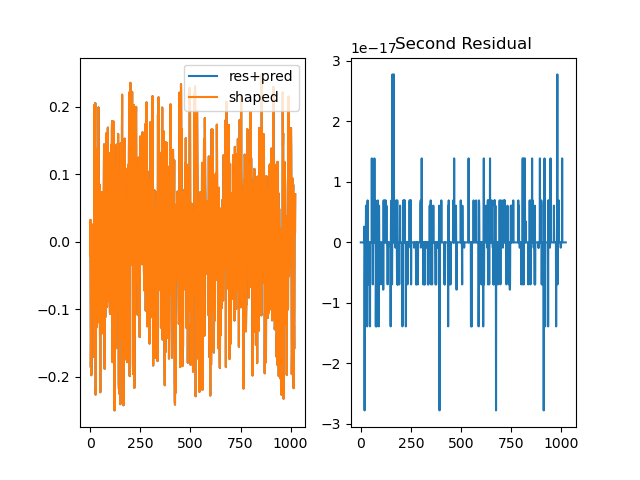

In [10]:
fig, axs = plt.subplots(ncols=2)
axs[0].plot(residual+predicted, label="res+pred")
axs[0].plot(shaped_noise, label="shaped")
axs[1].plot((residual+predicted) - shaped_noise)
axs[1].set_title("Second Residual")
axs[0].legend()

Figure **X** The shaped noise equals the predicted values plus the residual.  Thus we have decomposed the input signal into the ARMA model predicted values and a residual.

###  How is the "predicted" data being calculated

In [34]:
ma = np.array(arma_res.maparams)
ar = np.hstack((np.ones(1), np.array(arma_res.arparams)))
ar = np.array(arma_res.arparams)
lfilter_result = ssig.lfilter(ma, ar, residual)

In [35]:
print(f"len convolved = {len(lfilter_result)}")
print(f"len predicted = {len(predicted)}")

len convolved = 1024
len predicted = 1024


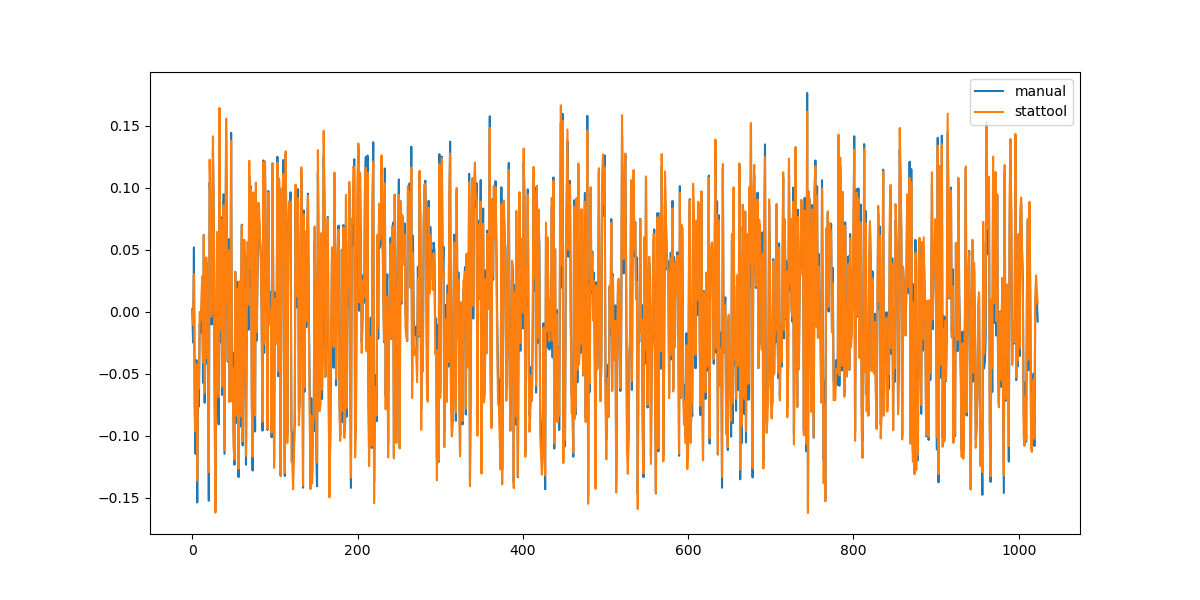

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
manual_prediction = lfilter_result
tsa_prediction = predicted
ax.plot(-manual_prediction, label="manual")
ax.plot(tsa_prediction, label="stattool")
# tsa_vs_manual_residual = manual_prediction+tsa_prediction
# ax.plot(tsa_vs_manual_residual, label="res")
ax.legend()


Figure **XX**: The predicted data and the filtered residual noise. 

Note that the misfit is concentrated at the start of the series, and I am not sure why.  Also, there is an offset term, which seems to grow with the order fo the filter.

However, to first order, in this simple example, we have the predicted data "equal" to the MA filtered data.

### there is an off-by-one to sort out still here

OK, so what has been done here, is that we have decomposed the shaped noise into an MA process on e(t) (the residual) and the residual itself.

That means that if we can express the filtering operation as a frequency domain multiplication, then we can apply the filter on the other side...

In [14]:
results = arma_res
fit_c = results.params[0] # = 0.0088
print(fit_c)
fit_ar1 = results.arparams[0] # = 0.4563
fit_ma1 = results.maparams[0] # = 0.2102
fit_ma2 = results.maparams[1] # = 0.2102
fit_ma3 = results.maparams[2] # = 0.2102
# make predictions for last 10 time steps
n=1021
#y_hat_manual = (y[-n-1:-1]-fit_c)*fit_ar1 + results.resid[-n-1:-1]*fit_ma1 + fit_c
y_hat_manual = (shaped_noise[-n-1:-1])*fit_ar1 + results.resid[-n-1:-1]*fit_ma1 + results.resid[-n-2:-2]*fit_ma2+ results.resid[-n-3:-3]*fit_ma3#+ fit_c

# make same predictions using statsmodels and compare 
y_hat_sm = results.predict(start=-n, dynamic=False)

pred_resid = y_hat_manual - y_hat_sm
print(abs(pred_resid).max())

0.9485386863751084
0.03724434678092421


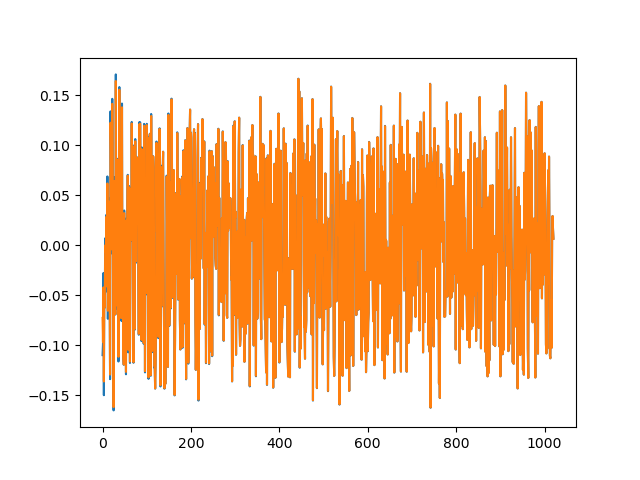

In [15]:
fig, ax = plt.subplots()
ax.plot(y_hat_manual)
ax.plot(y_hat_sm)

In [16]:
fit_ma1

0.09279411983808308

In [17]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1024
Model:                 ARIMA(1, 0, 3)   Log Likelihood                1221.397
Date:                Sun, 23 Oct 2022   AIC                          -2432.793
Time:                        17:10:32   BIC                          -2408.136
Sample:                             0   HQIC                         -2423.433
                               - 1024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9485      0.072     13.180      0.000       0.807       1.090
ma.L1          0.0928      0.095      0.974      0.330      -0.094       0.279
ma.L2         -0.9590      0.087    -11.034      0.000      -1.129      -0.789
ma.L3         -0.0527      0.032     -1.645      0.100      -0.116       0.010
sigma2         0.0054      0.001     10.101      0.000       0.004       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                42.32
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.00
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

In [19]:
#? what are these guys?
arma_res.maroots

array([  1.0399766 ,  -1.00049841, -18.23074994])

Lets take a look at the frequency response of the MA filter

In [20]:
arrgh = np.array([1, arma_res.arparams[0]])

In [21]:
# w, h = ssig.freqs(arma_res.maparams, [1])
ma_series = np.hstack((arma_res.maparams, np.zeros(N-len(MA))))
ma_frequency_response = np.fft.fft(ma_series)
w, h = ssig.freqz(arma_res.maparams, arma_res.arparams, whole=True, worN=1024)
#w, h = ssig.freqz(arma_res.maparams, arrgh, whole=True, worN=1024)
ma_frequency_response = h

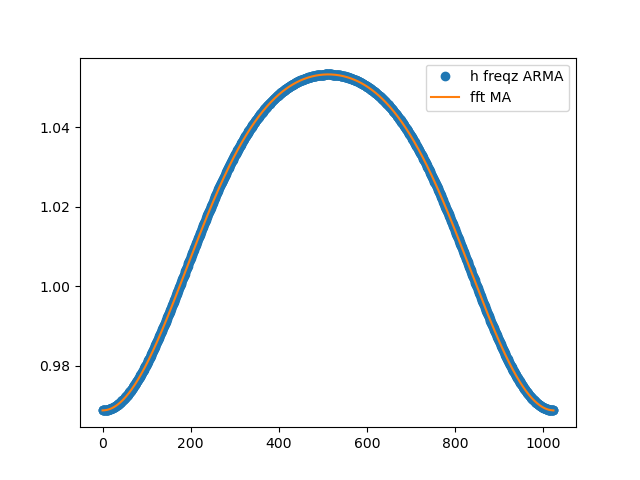

In [22]:
fig, ax = plt.subplots()
ax.plot(np.abs(h), 'o',label="h freqz ARMA")
ax.plot(np.abs(ma_frequency_response),  label="fft MA")
ax.legend()

And real, and imaginary

In [23]:
# compare_real_and_imaginary(h, ma_frequency_response, "h", "fft")

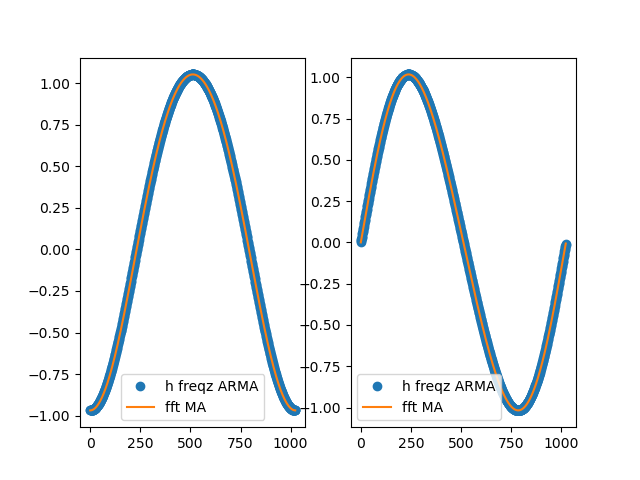

In [24]:
fig, axs = plt.subplots(ncols=2)
axs[0].plot(np.real(h), 'o',label="h freqz ARMA")
axs[0].plot(np.real(ma_frequency_response),  label="fft MA")
axs[0].legend()
axs[1].plot(np.imag(h), 'o',label="h freqz ARMA")
axs[1].plot(np.imag(ma_frequency_response),  label="fft MA")
axs[1].legend()

So, that means that we can FFT shaped_noise $y(t)$ without leakage, by using the following decompostion:

$y(t) = MA \ast res + res$

$F(y) = F(MA)  F(res) + F(res)$

In [25]:
fft_pred = np.fft.fft(predicted)
fft_res = np.fft.fft(residual)
fft_MA = h#ma_frequency_response
fft_MAres = - fft_res * fft_MA 

Text(0.5, 1.0, 'Imaginary')

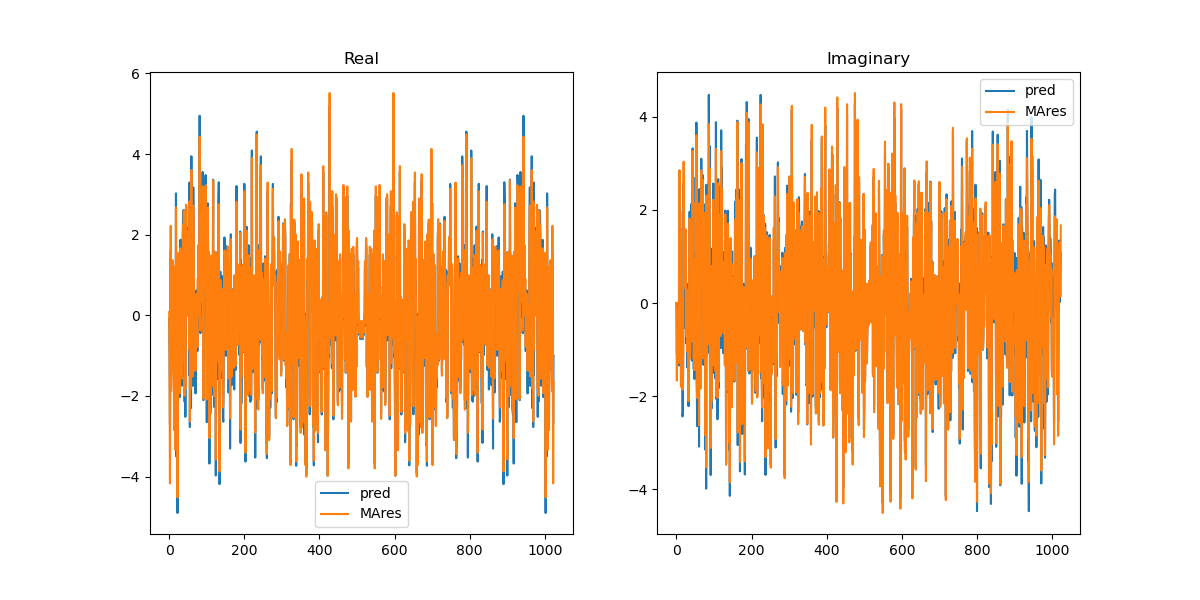

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].plot(np.real(fft_pred), label="pred")
axs[0].plot(np.real(fft_MAres),  label="MAres")
axs[0].legend()
axs[0].set_title("Real")
axs[1].plot(np.imag(fft_pred), label="pred")
axs[1].plot(np.imag(fft_MAres),  label="MAres")
axs[1].legend()
axs[1].set_title("Imaginary")

Text(0.5, 1.0, 'Phase Diff')

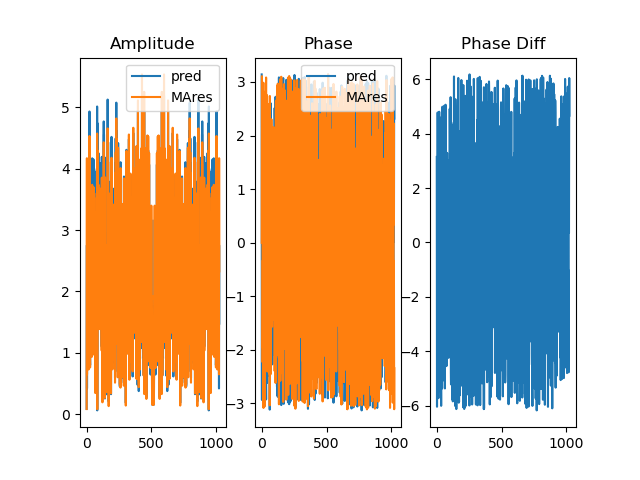

In [27]:
fig, axs = plt.subplots(ncols=3)
axs[0].plot(np.abs(fft_pred), label="pred")
axs[0].plot(np.abs(fft_MAres),  label="MAres")
axs[0].legend()
axs[0].set_title("Amplitude")
axs[1].plot(np.angle(fft_pred), label="pred")
axs[1].plot(-np.angle(fft_MAres),  label="MAres")
axs[1].legend()
axs[1].set_title("Phase")
axs[2].plot(np.angle(fft_pred)+np.angle(fft_MAres), label="diff")
#axs[1].plot(-np.angle(fft_MAres),  label="MAres")
#axs[1].legend()
axs[2].set_title("Phase Diff")

In [28]:
fft_shaped = np.fft.fft(shaped_noise)
#fft_MA = ma_frequency_response
fft_shaped2 = +fft_MAres + fft_res

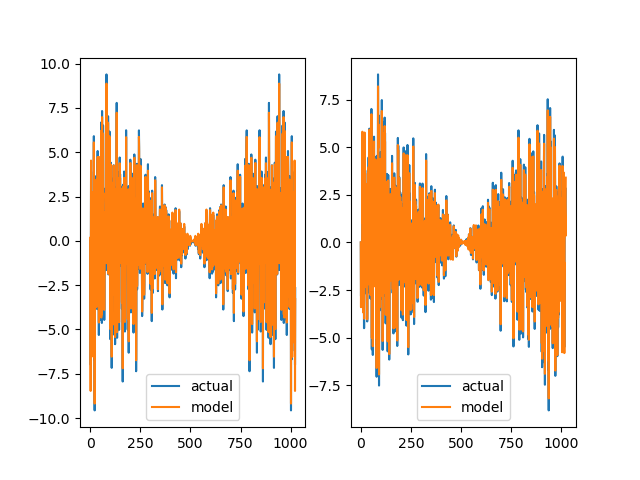

In [29]:
fig, axs = plt.subplots(ncols=2)
axs[0].plot(np.real(fft_shaped), label="actual")
axs[0].plot(np.real(fft_shaped2),  label="model")
axs[0].legend()
axs[1].plot(np.imag(fft_shaped), label="actual")
axs[1].plot(np.imag(fft_shaped2),  label="model")
axs[1].legend()